In [ ]:
# !pip install transformers

In [3]:
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, AutoTokenizer, BertModel, BertConfig, AutoModel, AdamW, AlbertTokenizer, AlbertConfig, AlbertModel
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from sklearn import metrics

In [4]:
train_data = pd.read_json('/kaggle/input/ru-paraphraser/train.jsonl', lines=True)
train_data.head(2)

,id,id_1,id_2,text_1,text_2,class
0,1,201,8159,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0
1,2,202,8158,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0


In [5]:
train_data['content'] = train_data.text_1 + ' | ' + train_data.text_2
train_data.drop(['id_1','id_2'], axis=1, inplace=True)
train_text = train_data.content
train_labels = train_data['class']

In [6]:
test_data = pd.read_json('/kaggle/input/ru-paraphraser/test.jsonl', lines=True)
test_data.head(2)

,id,id_1,id_2,text_1,text_2,class
0,25349,34420,34421,Цены на нефть восстанавливаются,Парламент Словакии поблагодарил народы бывшего...,-1
1,25360,34438,34439,"""Гоголь-центр"" покажет видеозапись скандальног...",Кехман запретил «Гоголь-центру» показывать вид...,-1


In [7]:
test_data['content'] = test_data.text_1 + ' | ' + test_data.text_2
test_data.drop(['id_1','id_2'], axis=1, inplace=True)
test_text = test_data.content
test_labels = test_data['class']

In [38]:
train_labels.unique()

array([ 0, -1,  1])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


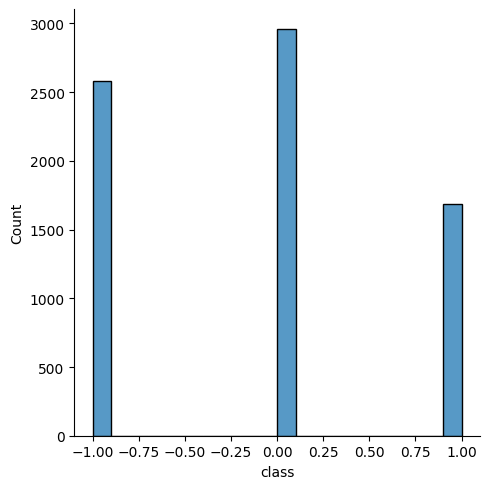

In [39]:
sns.displot(train_labels)

In [40]:
train = pd.concat([train_text, train_labels], sort=False, axis=1)
test = pd.concat([test_text, test_labels], sort=False, axis=1)

In [41]:
train['class'] = train['class'].astype(str)
test['class'] = test['class'].astype(str)
# train = train.loc[train_data['class'] != 0] #Делаем бинарную классификацию
# test = test.loc[test_data['class'] != 0]
train.loc[train['class'] =='-1', 'class'] = '2'
test.loc[test['class'] =='-1', 'class'] = '2'

In [10]:
test['class'] = test['class'].astype(str)
test.loc[test['class'] =='-1', 'class'] = '2'

Добавляем перевод на англ

In [46]:
!pip install -U deep-translator

In [47]:
#
from deep_translator import GoogleTranslator 
translator = GoogleTranslator()  
translate_text = translator.translate('Привет',lang_tgt='en')  
print(translate_text)

Hello


In [52]:
train['content_tr'] = train['content'].apply(lambda x: translator.translate(x,lang_tgt='en') if True else 0)

In [53]:
train['content_tr']

0       The police will be allowed to shoot to kill at...
1       They decided to limit the police’s right to en...
2       The Egyptian President declared a state of eme...
3       Russians returning from Syria are concerned ab...
4       Two EMERCOM planes with Russians on board retu...
                              ...                        
7222    Putin dismissed a number of generals | Putin r...
7223    Clouds over Moscow on Victory Day will dispers...
7224    Ljubljana will celebrate Victory Day together ...
7225    Nine Air Force planes will clear the clouds ov...
7226    On May 9, the St. Petersburg metro will operat...
Name: content_tr, Length: 7227, dtype: object

In [54]:
train.head()

,content,class,content_tr
0,Полицейским разрешат стрелять на поражение по ...,0,The police will be allowed to shoot to kill at...
1,Право полицейских на проникновение в жилище ре...,0,They decided to limit the police’s right to en...
2,Президент Египта ввел чрезвычайное положение в...,0,The Egyptian President declared a state of eme...
3,Вернувшихся из Сирии россиян волнует вопрос тр...,2,Russians returning from Syria are concerned ab...
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,0,Two EMERCOM planes with Russians on board retu...


In [55]:
train.to_csv('train_translated.csv', index=False)

In [8]:
train_translated = pd.read_csv('/kaggle/input/ru-paraphraser-translated/train_translated.csv')
train_translated.head()
train = train_translated.copy()

In [9]:
test_translated = pd.read_csv('/kaggle/input/ru-paraphraser-translated/test_translated.csv')
test_translated.head()
test = test_translated.copy()

-------

In [10]:
train['class'] = train['class'].astype(str)
test['class'] = test['class'].astype(str)
train.loc[train['class'] =='-1', 'class'] = '2'
test.loc[test['class'] =='-1', 'class'] = '2'

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


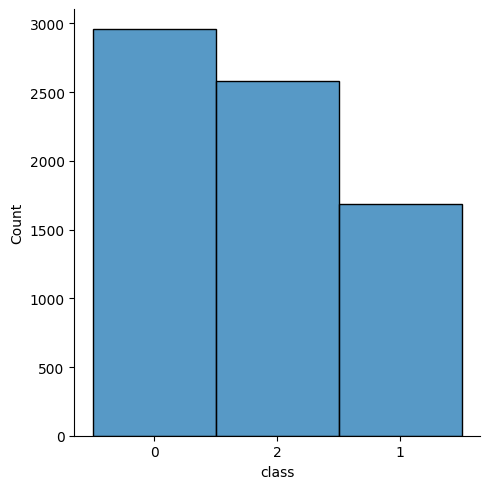

In [11]:
sns.displot(train['class'])

In [12]:
train['class'] = train['class'].astype(str)
test['class'] = test['class'].astype(str)

In [13]:
for i in ['0', '1', '2']: 
    train[i] = train['class'].apply(lambda x: 1 if i in x else 0)
    test[i] = test['class'].apply(lambda x: 1 if i in x else 0)

In [14]:
train.drop(['class'], axis=1, inplace=True)
test.drop(['class'], axis=1, inplace=True)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [15]:
train.head(2)

,content,content_tr,0,1,2
0,Полицейским разрешат стрелять на поражение по ...,The police will be allowed to shoot to kill at...,1,0,0
1,Право полицейских на проникновение в жилище ре...,They decided to limit the police’s right to en...,1,0,0


In [16]:
train.drop(['content'], axis=1, inplace=True)
test.drop(['content'], axis=1, inplace=True)

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
target_cols = [col for col in train.columns if col not in ['content_tr']]
target_cols

['0', '1', '2']

-------------------------------

In [19]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained('FacebookAI/roberta-base', max_len=512)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [20]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [21]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content_tr
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [22]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [24]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('FacebookAI/roberta-base')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_R = BERTClass()
model_R.to(device);

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_R.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%100 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [27]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [28]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [29]:
# MAX_LEN = 200
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5 ruroberta
for epoch in range(EPOCHS):
  train(epoch, model_R)

Epoch: 0, Loss:  0.6761324405670166
Epoch: 0, Loss:  0.46525976061820984
Epoch: 0, Loss:  0.41925740242004395
Epoch: 1, Loss:  0.42075347900390625
Epoch: 1, Loss:  0.27831971645355225
Epoch: 1, Loss:  0.49325883388519287
Epoch: 2, Loss:  0.3948259949684143
Epoch: 2, Loss:  0.27733784914016724
Epoch: 2, Loss:  0.3420601487159729


In [30]:
test_outputs, test_targets = test(model_R)

In [31]:
train_outputs, train_targets = test_model_by_train(model_R)

In [32]:
np.savetxt("Roberta_outputs_3cl_translated.csv", test_outputs, delimiter=";")
np.savetxt("Roberta_outputs_train_3cl_translated.csv", train_outputs, delimiter=";")

In [33]:
train_outputs = np.array(train_outputs) >= 0.5

In [34]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append(0)
    else:
        if each[1] > 0:
           targets.append(1)
        else:
           targets.append(2)

In [35]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append(0)
    else:
        if each[1]:
           outputs.append(1)
        else:
           outputs.append(2)

In [36]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.8880586688805867
F1 Score (Micro) = 0.8880586688805867
F1 Score (Macro) = 0.8845177881138705
F1 Score (Weighted) = 0.888121029847799


In [37]:
from sklearn import metrics

test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6928274428274428
F1 Score (Micro) = 0.7047274606044949
F1 Score (Macro) = 0.6905331300138657
F1 Score (Weighted) = 0.7037098349855279


In [38]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [39]:
new_targets = []
for each in test_targets:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

In [40]:
accuracy = metrics.accuracy_score(new_targets, new_outputs)
f1_score_micro = metrics.f1_score(new_targets, new_outputs, average='micro')
f1_score_macro = metrics.f1_score(new_targets, new_outputs, average='macro')
f1_score_weighted = metrics.f1_score(new_targets, new_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.7021829521829522
F1 Score (Micro) = 0.7021829521829522
F1 Score (Macro) = 0.6876829848664233
F1 Score (Weighted) = 0.7011645458703113


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

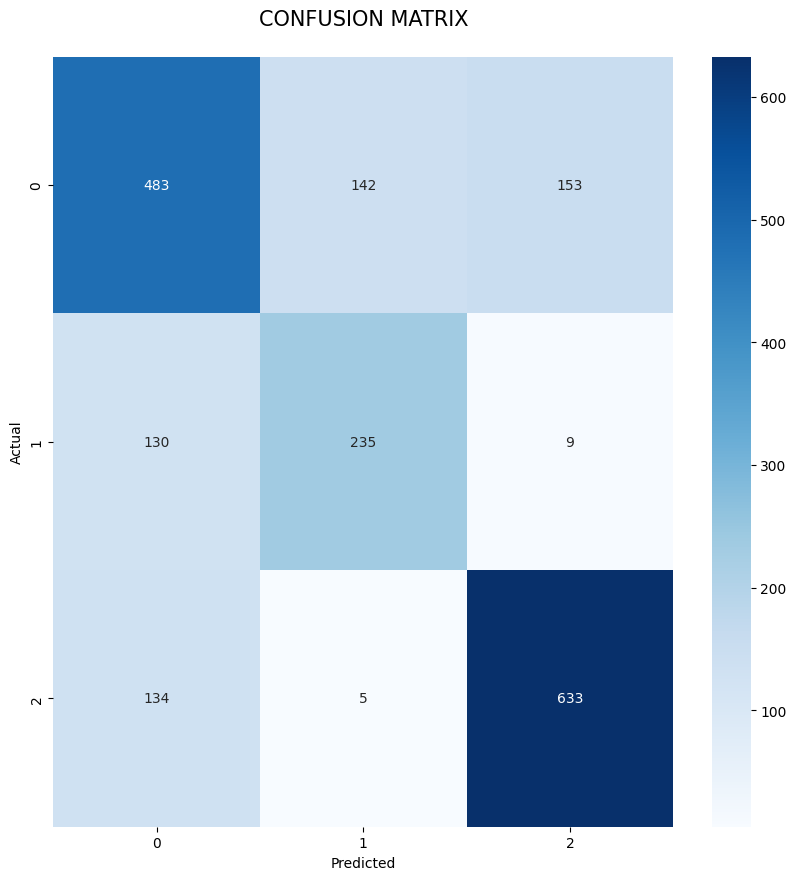

In [41]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

-------------------------------------

In [53]:
tokenizer = AutoTokenizer.from_pretrained('google-bert/bert-base-uncased', max_len=512)

In [54]:
MAX_LEN = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [55]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df.content_tr
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [56]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [58]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.gpt = AutoModel.from_pretrained('google-bert/bert-base-uncased')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.gpt(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_A = BERTClass()
model_A.to(device);

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [62]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_A.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [73]:
for epoch in range(EPOCHS):
  train(epoch, model_A)

Epoch: 0, Loss:  0.229618638753891
Epoch: 0, Loss:  0.1679684817790985
Epoch: 0, Loss:  0.3208617568016052
Epoch: 1, Loss:  0.12376166880130768
Epoch: 1, Loss:  0.08218751102685928
Epoch: 1, Loss:  0.14284110069274902
Epoch: 2, Loss:  0.048092685639858246
Epoch: 2, Loss:  0.12755440175533295
Epoch: 2, Loss:  0.33730238676071167


In [74]:
test_outputs_A, test_targets_A = test(model_A)

In [75]:
train_outputs_A, train_targets_A = test_model_by_train(model_A)

In [76]:
np.savetxt("bert_base_outputs_train_cl3.csv", train_outputs_A, delimiter=";")
np.savetxt("bert_base__outputs_cl3.csv", test_outputs_A, delimiter=";")

In [77]:
from sklearn import metrics

outputs = np.array(test_outputs_A) >= 0.5
accuracy = metrics.accuracy_score(test_targets_A, outputs)
f1_score_micro = metrics.f1_score(test_targets_A, outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets_A, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5821205821205822
F1 Score (Micro) = 0.5864504315982213
F1 Score (Macro) = 0.5867836591723591


In [78]:
new_outputs = []
for each in test_outputs_A:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [79]:
new_targets = []
for each in test_targets_A:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

Text(0.5, 1.0, 'CONFUSION MATRIX\n')

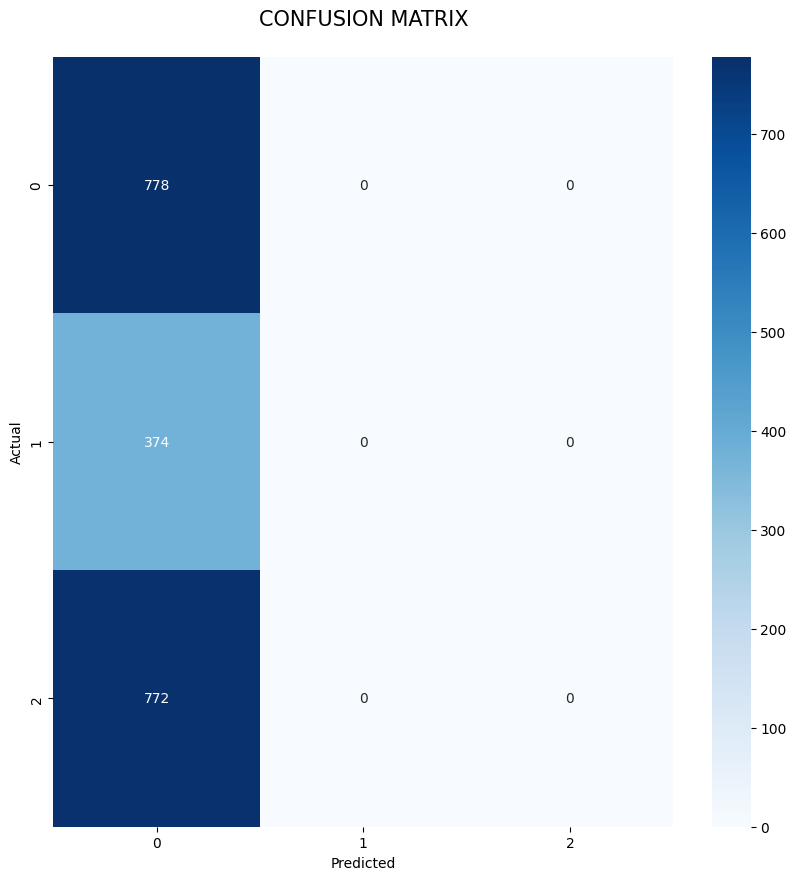

In [80]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

-------------------------------

In [97]:
tokenizer = AutoTokenizer.from_pretrained('FacebookAI/xlm-roberta-base', max_len=512)

In [98]:
MAX_LEN = 200
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5

In [99]:
class BERTDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.df = df
        self.max_len = max_len
        self.text = df['content_tr']
        self.tokenizer = tokenizer
        self.targets = df[target_cols].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [101]:
train_dataset = BERTDataset(train, tokenizer, MAX_LEN)
test_dataset = BERTDataset(test, tokenizer, MAX_LEN)

In [102]:
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE,
                          num_workers=2, shuffle=True)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)
train_for_test_loader = DataLoader(train_dataset, batch_size=VALID_BATCH_SIZE,
                          num_workers=2, shuffle=False)#, pin_memory=True)

In [104]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.roberta = AutoModel.from_pretrained('FacebookAI/xlm-roberta-base')
        self.fc = torch.nn.Linear(768, 3)

    def forward(self, ids, mask, token_type_ids):
        _, features = self.roberta(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.fc(features)
        return output

model_B = BERTClass()
model_B.to(device);

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

In [105]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = AdamW(params =  model_B.parameters(), lr=LEARNING_RATE, weight_decay=1e-6)
scheduler1 = ExponentialLR(optimizer, gamma=0.9)
scheduler2 = MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [106]:
def train(epoch, model):
    model.train()
    for _,data in enumerate(train_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.float)

      outputs = model(ids, mask, token_type_ids)

      loss = loss_fn(outputs, targets)
      if _%100 == 0:
          print(f'Epoch: {epoch}, Loss:  {loss.item()}')

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

In [107]:
def test(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [108]:
def test_model_by_train(model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(train_for_test_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [109]:
# MAX_LEN = 200
# TRAIN_BATCH_SIZE = 32
# VALID_BATCH_SIZE = 32
# EPOCHS = 3
# LEARNING_RATE = 2e-5 ruroberta
for epoch in range(EPOCHS):
  train(epoch, model_B)

Epoch: 0, Loss:  0.6834944486618042
Epoch: 0, Loss:  0.5234051942825317
Epoch: 0, Loss:  0.5165340304374695
Epoch: 1, Loss:  0.35786473751068115
Epoch: 1, Loss:  0.48917484283447266
Epoch: 1, Loss:  0.37729477882385254
Epoch: 2, Loss:  0.39393728971481323
Epoch: 2, Loss:  0.4090542495250702
Epoch: 2, Loss:  0.22856329381465912


In [110]:
test_outputs, test_targets = test(model_B)

In [111]:
train_outputs, train_targets = test_model_by_train(model_B)

In [112]:
np.savetxt("xlm_roberta_outputs_paraphrases_cl3_translated.csv", test_outputs, delimiter=";")
np.savetxt("xlm_roberta_outputs_train_paraphrases_cl3_translated.csv", train_outputs, delimiter=";")

In [113]:
train_outputs = np.array(train_outputs) >= 0.5

In [114]:
targets = []
for each in train_targets:
    if each[0] > 0:
        targets.append(0)
    else:
#         targets.append(1)
        if each[1] > 0:
           targets.append(1)
        else:
           targets.append(2)

In [115]:
outputs = []
for each in train_outputs:
    if each[0]:
        outputs.append(0)
    else:
#         outputs.append(1)
        if each[1]:
           outputs.append(1)
        else:
           outputs.append(2)

In [116]:
accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
f1_score_weighted = metrics.f1_score(targets, outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.8368617683686177
F1 Score (Micro) = 0.8368617683686177
F1 Score (Macro) = 0.8305150587816695
F1 Score (Weighted) = 0.8366814106769058


In [117]:
from sklearn import metrics

test_outputs = np.array(test_outputs) >= 0.5
accuracy = metrics.accuracy_score(test_targets, test_outputs)
f1_score_micro = metrics.f1_score(test_targets, test_outputs, average='micro')
f1_score_macro = metrics.f1_score(test_targets, test_outputs, average='macro')
f1_score_weighted = metrics.f1_score(test_targets, test_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6299376299376299
F1 Score (Micro) = 0.6450441100155683
F1 Score (Macro) = 0.6227998188364151
F1 Score (Weighted) = 0.64489354596048


In [118]:
new_outputs = []
for each in test_outputs:
    if each[0]:
      new_outputs.append(0)
    elif each[1]:
      new_outputs.append(1)
    else:
      new_outputs.append(2)

In [119]:
# new_targets = []
# for each in test_targets:
#   tar = []
#   for i in range(0, 2, 1):
#     tar.append(int(each[i - 1] * (i)))
#   new_targets.append(max(tar))
new_targets = []
for each in test_targets:
    if each[0]:
      new_targets.append(0)
    elif each[1]:
      new_targets.append(1)
    else:
      new_targets.append(2)

In [120]:
accuracy = metrics.accuracy_score(new_targets, new_outputs)
f1_score_micro = metrics.f1_score(new_targets, new_outputs, average='micro')
f1_score_macro = metrics.f1_score(new_targets, new_outputs, average='macro')
f1_score_weighted = metrics.f1_score(new_targets, new_outputs, average='weighted')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")
print(f"F1 Score (Weighted) = {f1_score_weighted}")

Accuracy Score = 0.6351351351351351
F1 Score (Micro) = 0.6351351351351351
F1 Score (Macro) = 0.6136926072589365
F1 Score (Weighted) = 0.6339308110262596


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

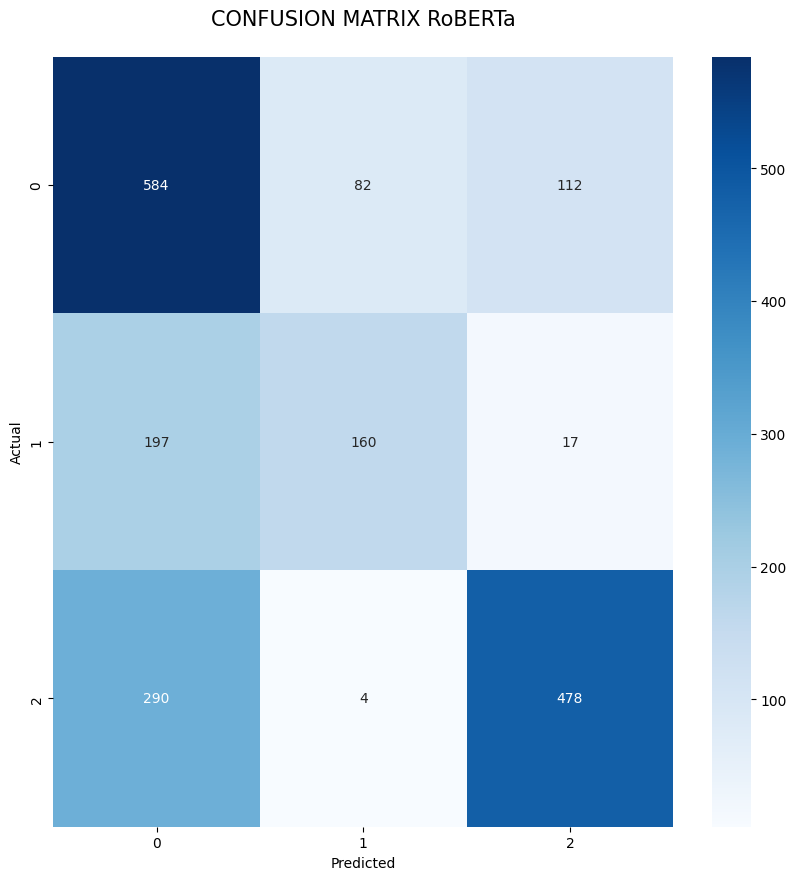

In [121]:
conf_mat = metrics.confusion_matrix(new_targets, new_outputs)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

-----------------------------------------------------------

In [28]:
df_train_R = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/Roberta_outputs_train_3cl_translated (1).csv", header=None, sep=';')
df_train_A = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/xlm_roberta_outputs_train_paraphrases_cl3_translated.csv", header=None, sep=';')
df_train_B = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/bert_base_outputs_train_cl3.csv", header=None, sep=';')
df_train_R = df_train_R.rename(columns={0: 'R_0', 1: 'R_1', 2: 'R_2'})
df_train_A = df_train_A.rename(columns={0: 'A_0', 1: 'A_1', 2: 'A_2'})
df_train_B = df_train_B.rename(columns={0: 'B_0', 1: 'B_1', 2: 'B_2'})

In [29]:
df_train_B

,B_0,B_1,B_2
0,0.976976,0.016907,0.011804
1,0.911812,0.068552,0.019764
2,0.984508,0.018335,0.006421
3,0.009637,0.002798,0.991348
4,0.775298,0.189967,0.022499
...,...,...,...
7222,0.977232,0.021740,0.010533
7223,0.090682,0.005540,0.916619
7224,0.020997,0.003311,0.980046
7225,0.015065,0.003103,0.985233


In [42]:
df_train = pd.concat([
    df_train_R, df_train_A, df_train_B], axis=1)

In [43]:
df_train

,R_0,R_1,R_2,A_0,A_1,A_2,B_0,B_1,B_2
0,0.878086,0.142390,0.027153,0.719611,0.260222,0.026014,0.976976,0.016907,0.011804
1,0.850362,0.097642,0.062272,0.752430,0.052278,0.178472,0.911812,0.068552,0.019764
2,0.773491,0.027613,0.208469,0.686633,0.029219,0.309787,0.984508,0.018335,0.006421
3,0.009353,0.004002,0.989122,0.092415,0.003065,0.926503,0.009637,0.002798,0.991348
4,0.789103,0.087023,0.081311,0.654966,0.022189,0.366809,0.775298,0.189967,0.022499
...,...,...,...,...,...,...,...,...,...
7222,0.910074,0.045340,0.072438,0.790663,0.074467,0.114445,0.977232,0.021740,0.010533
7223,0.008473,0.004398,0.990807,0.100714,0.003173,0.912195,0.090682,0.005540,0.916619
7224,0.009086,0.004618,0.990945,0.095693,0.003268,0.923463,0.020997,0.003311,0.980046
7225,0.007477,0.005408,0.991851,0.175394,0.004349,0.854111,0.015065,0.003103,0.985233


In [44]:
train

,content,class
0,Полицейским разрешат стрелять на поражение по ...,0
1,Право полицейских на проникновение в жилище ре...,0
2,Президент Египта ввел чрезвычайное положение в...,0
3,Вернувшихся из Сирии россиян волнует вопрос тр...,2
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,0
...,...,...
7222,Путин освободил от должности ряд генералов | П...,0
7223,Облака над Москвой в День Победы разгонят девя...,2
7224,Любляна отпразднует День Победы вместе с Москв...,2
7225,Девять самолетов ВВС разгонят облака над Москв...,2


In [45]:
y_train = train['class']
y_train

0       0
1       0
2       0
3       2
4       0
       ..
7222    0
7223    2
7224    2
7225    2
7226    2
Name: class, Length: 7227, dtype: object

In [46]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=0.5, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LinearSVC(C=0.5, class_weight='balanced', max_iter=100000, random_state=42)

In [47]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=500)
clf.fit(df_train, y_train)

Learning rate set to 0.157217
0:	learn: 0.8314195	total: 70.4ms	remaining: 35.1s
1:	learn: 0.6615801	total: 75.8ms	remaining: 18.9s
2:	learn: 0.5425410	total: 81.6ms	remaining: 13.5s
3:	learn: 0.4542276	total: 87.2ms	remaining: 10.8s
4:	learn: 0.3850755	total: 92.8ms	remaining: 9.18s
5:	learn: 0.3286198	total: 98.5ms	remaining: 8.11s
6:	learn: 0.2834310	total: 104ms	remaining: 7.33s
7:	learn: 0.2467145	total: 110ms	remaining: 6.76s
8:	learn: 0.2170849	total: 116ms	remaining: 6.32s
9:	learn: 0.1930773	total: 121ms	remaining: 5.94s
10:	learn: 0.1724474	total: 127ms	remaining: 5.64s
11:	learn: 0.1549371	total: 132ms	remaining: 5.38s
12:	learn: 0.1402874	total: 138ms	remaining: 5.17s
13:	learn: 0.1277330	total: 144ms	remaining: 4.99s
14:	learn: 0.1177012	total: 149ms	remaining: 4.83s
15:	learn: 0.1085631	total: 155ms	remaining: 4.69s
16:	learn: 0.1011788	total: 161ms	remaining: 4.56s
17:	learn: 0.0948325	total: 166ms	remaining: 4.45s
18:	learn: 0.0890062	total: 172ms	remaining: 4.35s
19:	l

In [48]:
df_test_R = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/Roberta_outputs_3cl_translated (1).csv", header=None, sep=';')
df_test_A = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/xlm_roberta_outputs_paraphrases_cl3_translated.csv", header=None, sep=';')
df_test_B = pd.read_csv("/kaggle/input/outputs-paraphrases-translated/bert_base__outputs_cl3.csv", header=None, sep=';')
df_test_R = df_test_R.rename(columns={0: 'R_0', 1: 'R_1', 2: 'R_2'})
df_test_A = df_test_A.rename(columns={0: 'A_0', 1: 'A_1', 2: 'A_2'})
df_test_B = df_test_B.rename(columns={0: 'B_0', 1: 'B_1', 2: 'B_2'})

In [49]:
df_test = pd.concat([
    df_test_R, df_test_A, df_test_B], axis=1)

In [50]:
y_pred = clf.predict(df_test)

In [51]:
test_labels = test['class']
test_labels

0       2
1       2
2       2
3       2
4       2
       ..
1919    1
1920    0
1921    2
1922    2
1923    2
Name: class, Length: 1924, dtype: object

In [52]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6585239085239085
F1 Score (Micro) = 0.6585239085239085
F1 Score (Macro) = 0.644124745807468


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

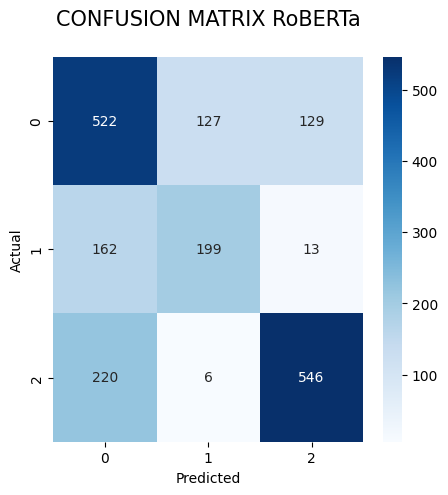

In [53]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)

In [54]:
from sklearn.svm import LinearSVC
import optuna
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [55]:
X_train, X_valid, train_labels, valid_labels = train_test_split(df_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [56]:
X_train

,R_0,R_1,R_2,A_0,A_1,A_2,B_0,B_1,B_2
3035,0.823725,0.048296,0.109582,0.799023,0.079534,0.111659,0.980938,0.007195,0.019831
6229,0.105422,0.910530,0.006800,0.733258,0.220637,0.029468,0.009480,0.983923,0.014051
5637,0.907419,0.111390,0.029072,0.683825,0.023325,0.347008,0.970846,0.044687,0.005813
5131,0.843081,0.237015,0.014387,0.758292,0.180877,0.042217,0.950193,0.035501,0.022525
5483,0.775622,0.346178,0.008496,0.752640,0.220451,0.030130,0.930848,0.019436,0.058533
...,...,...,...,...,...,...,...,...,...
6042,0.902382,0.050187,0.062923,0.790021,0.065071,0.127814,0.966580,0.046744,0.005438
1820,0.170924,0.004999,0.821685,0.062846,0.002691,0.945380,0.006834,0.003137,0.995357
6485,0.691663,0.355115,0.011494,0.529024,0.385031,0.015568,0.022753,0.960036,0.011538
4989,0.918281,0.119224,0.024399,0.796667,0.129277,0.063755,0.928712,0.048781,0.013211


In [57]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("lr_c", 1e-2, 1e3, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-04-10 10:29:17,799] A new study created in memory with name: no-name-ba173378-2ec3-457d-a476-c2fe0e33782b
[I 2024-04-10 10:29:18,356] Trial 0 finished with value: 0.976568884293381 and parameters: {'lr_c': 373.6389926886903}. Best is trial 0 with value: 0.976568884293381.
[I 2024-04-10 10:29:18,420] Trial 1 finished with value: 0.9682943535969466 and parameters: {'lr_c': 0.038595948387587696}. Best is trial 0 with value: 0.976568884293381.
[I 2024-04-10 10:29:18,762] Trial 2 finished with value: 0.976568884293381 and parameters: {'lr_c': 67.07400906552131}. Best is trial 0 with value: 0.976568884293381.
[I 2024-04-10 10:29:19,059] Trial 3 finished with value: 0.976568884293381 and parameters: {'lr_c': 38.31412389550749}. Best is trial 0 with value: 0.976568884293381.
[I 2024-04-10 10:29:19,143] Trial 4 finished with value: 0.9733322286333145 and parameters: {'lr_c': 0.5117438283176714}. Best is trial 0 with value: 0.976568884293381.
[I 2024-04-10 10:29:19,211] Trial 5 finished 

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.976568884293381], datetime_start=datetime.datetime(2024, 4, 10, 10, 29, 17, 801316), datetime_complete=datetime.datetime(2024, 4, 10, 10, 29, 18, 355888), params={'lr_c': 373.6389926886903}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=1000.0, log=True, low=0.01, step=None)}, trial_id=0, value=None)


In [58]:
clf = LogisticRegression(C=60, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LogisticRegression(C=60, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [59]:
y_pred = clf.predict(df_test)

In [60]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6554054054054054
F1 Score (Micro) = 0.6554054054054054
F1 Score (Macro) = 0.6446445375656946


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

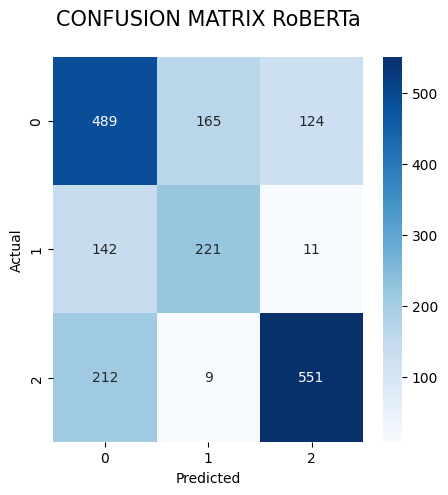

In [61]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [62]:
from sklearn.svm import LinearSVC
clf = LinearSVC(C=15, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LinearSVC(C=15, class_weight='balanced', max_iter=100000, random_state=42)

In [63]:
y_pred = clf.predict(df_test)

In [64]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6538461538461539
F1 Score (Micro) = 0.6538461538461539
F1 Score (Macro) = 0.6413742454574382


Text(0.5, 1.0, 'CONFUSION MATRIX RoBERTa\n')

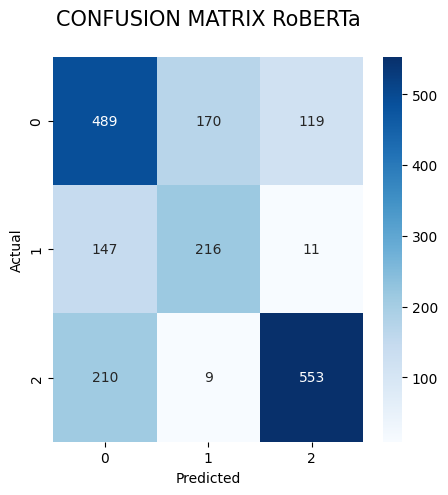

In [65]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX RoBERTa\n", size=15)

In [66]:
from sklearn.svm import LinearSVC
import optuna
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [67]:
X_train, X_valid, train_labels, valid_labels = train_test_split(df_train, y_train, test_size=0.2, random_state=42, shuffle=True, stratify=y_train)

In [68]:
def objective(trial):
    global X_train, train_labels, X_valid, valid_labels

    c = trial.suggest_float("lr_c", 1e-2, 1e3, log=True)

    clf = LogisticRegression(C=c, random_state=42, class_weight='balanced', max_iter=100000)
    clf.fit(X_train, train_labels)

    return metrics.f1_score(clf.predict(X_valid), valid_labels, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2024-04-10 10:29:52,828] A new study created in memory with name: no-name-3a0e7772-bb6d-4da1-819f-8567a2f67a96
[I 2024-04-10 10:29:52,903] Trial 0 finished with value: 0.9715155728227153 and parameters: {'lr_c': 0.21946805351192783}. Best is trial 0 with value: 0.9715155728227153.
[I 2024-04-10 10:29:53,012] Trial 1 finished with value: 0.975673316170674 and parameters: {'lr_c': 1.6458139274351695}. Best is trial 1 with value: 0.975673316170674.
[I 2024-04-10 10:29:53,366] Trial 2 finished with value: 0.9771726168768508 and parameters: {'lr_c': 222.7502029409243}. Best is trial 2 with value: 0.9771726168768508.
[I 2024-04-10 10:29:53,679] Trial 3 finished with value: 0.976568884293381 and parameters: {'lr_c': 78.045950971833}. Best is trial 2 with value: 0.9771726168768508.
[I 2024-04-10 10:29:53,870] Trial 4 finished with value: 0.9764220644045293 and parameters: {'lr_c': 10.556255586218901}. Best is trial 2 with value: 0.9771726168768508.
[I 2024-04-10 10:29:53,929] Trial 5 finish

FrozenTrial(number=2, state=TrialState.COMPLETE, values=[0.9771726168768508], datetime_start=datetime.datetime(2024, 4, 10, 10, 29, 53, 13637), datetime_complete=datetime.datetime(2024, 4, 10, 10, 29, 53, 366141), params={'lr_c': 222.7502029409243}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=1000.0, log=True, low=0.01, step=None)}, trial_id=2, value=None)


In [69]:
clf = LogisticRegression(C=20, random_state=42, class_weight='balanced', max_iter=100000)
clf.fit(df_train, y_train)

LogisticRegression(C=20, class_weight='balanced', max_iter=100000,
                   random_state=42)

In [70]:
y_pred = clf.predict(df_test)

In [71]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.6548856548856549
F1 Score (Micro) = 0.6548856548856549
F1 Score (Macro) = 0.6441844396222312


Text(0.5, 1.0, 'CONFUSION MATRIX\n')

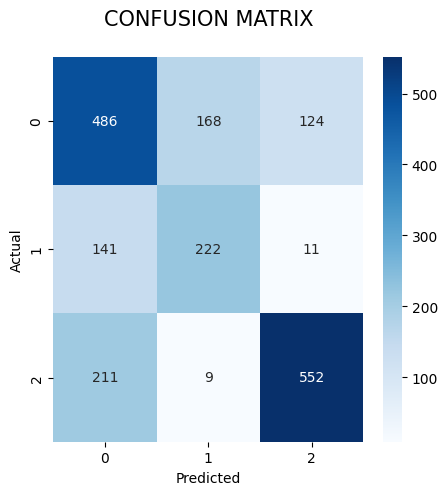

In [72]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX\n", size=15)